# Hotel Review Sentiment Analysis Part 2: EDA
## Adura ABIONA, PhD (UNSW)
### 4 May, 2017

## Introduction

This is the **Part II** of the **Hotel Review Sentiment Analysis** of Australian hotels, from four major cities (Canberra, Sydney, Melbourne and Brisbane), based on reviewers' opionions (on a numerical scale of 1-5) from [**TripAdvisor**](http://www.tripadvisor.com.au) website. This part is focused on **Exploratory Data Analysis (EDA)** of the reviews. 

In [136]:
import glob, os, string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
matplotlib.style.use('ggplot')
%matplotlib inline 
sep = "~"
DataDir = "Datasets/" 
#nltk.download() # download the english stopwords corpus and the punkt package and maybe the porter stemmer if not present
print(pd.__version__)

0.18.1


#### The block of code below reads the review details for the hotels from the 4 major cities in Australia into a dataframe.

In [137]:
review_feats = ['id', 'title','body','rati','value','locat','sleep','rooms','clean','servi','other']
citys = ['Canberra', 'Sydney', 'Melbourne', 'Brisbane']
review_df = pd.DataFrame() #creates a new dataframe that's empty
for city in citys:
    citydir = os.path.join(os.getcwd(), DataDir + city)
    for file in glob.glob(os.path.join(citydir,"*-review.mcsv")): 
        review_df = review_df.append(pd.read_csv(os.path.join(citydir, file), sep=sep, header=None, names = review_feats), ignore_index=True)

print(review_df.shape)
review_df.head()

(27868, 11)


,id,title,body,rati,value,locat,sleep,rooms,clean,servi,other
0,review_478470647,“Waste of money”,"From the moment we walked into the Adobe,we kn...",1,1,NaN,NaN,2.0,NaN,1.0,NaN
1,review_476951438,“Well appointed room”,On check in was a queue of 6 waiting with only...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,review_476646112,"“Forgotten property ""vanished into thin air"" a...",Review submitted on behalf of my wife who was ...,2,4,NaN,NaN,4.0,NaN,2.0,NaN
3,review_475716850,“Everything you need and more”,This is a great hotel. Clean and really comfor...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_474490948,"“Super handy for shops, food and transport”",This is my go to accommodation in Canberra. Cl...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
review_dfx = review_df[['id', 'title', 'body', 'rati']].copy()
review_dfx['rati'] = pd.to_numeric(review_dfx['rati'], errors='coerce') 
review_dfx = review_dfx.dropna(axis=0)
print(review_dfx.rati.unique())
print(review_dfx.shape)
review_dfx.head()

[ 1.  3.  2.  5.  4.]
(27408, 4)


,id,title,body,rati
0,review_478470647,“Waste of money”,"From the moment we walked into the Adobe,we kn...",1.0
1,review_476951438,“Well appointed room”,On check in was a queue of 6 waiting with only...,3.0
2,review_476646112,"“Forgotten property ""vanished into thin air"" a...",Review submitted on behalf of my wife who was ...,2.0
3,review_475716850,“Everything you need and more”,This is a great hotel. Clean and really comfor...,5.0
4,review_474490948,"“Super handy for shops, food and transport”",This is my go to accommodation in Canberra. Cl...,5.0


### Rating Category Distribution for Reviews
The rating categories (1,2,3,4, and 5) are from now on color coded with red, orange, blue, purple and green respectively.

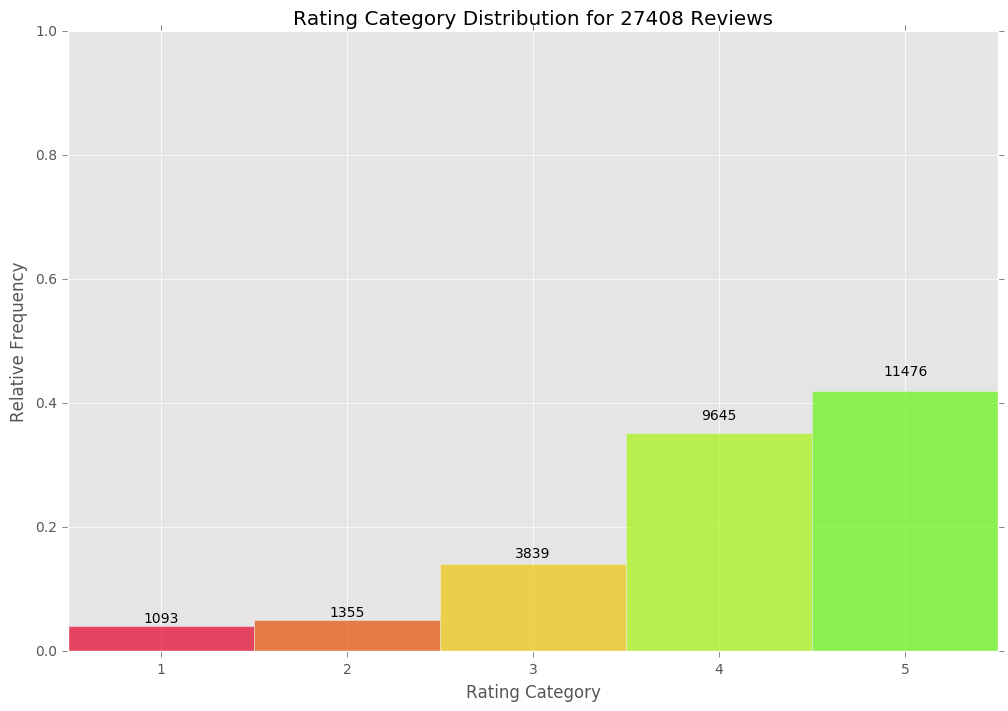

In [139]:
rat_cat = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 ratings respectively

rat_labels = np.array([x_rat+1 for x_rat in range(rat_cat)])
rat_cat_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(rat_cat)
rat_cat_absolute_freq = review_dfx.rati.value_counts(ascending=True)
rat_cat_relative_freq = np.array(rat_cat_absolute_freq)/float(sum(rat_cat_absolute_freq))

rects = plt.bar(bar_plot_indices, rat_cat_relative_freq, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(rat_cat_absolute_freq[idx+1]), ha='center', va='bottom')

plt.xticks(bar_plot_indices+.5, rat_labels)
plt.xlabel('Rating Category')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Rating Category Distribution for {0} Reviews'.format(len(review_dfx)))

plt.show()

In [164]:
#Some words (e.g. no, not, more, most etc.) have been removed from the standard stopwords available in NLTK. 
#It’s done so because those words can have some sentiment impact in our review dataset.
custom_stopwords = set(stopwords.words('english') + ["n't", "'ve", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS) 
                 + ['hotel', 'room', 'apartment', 'bathroom', 'bedroom', 'bed', 'also'] 
                 + ['canberra', 'sydney', 'melbourne', 'brisbane']) - set(('over', 'under', 'below', 'more', 'most', 'no', 
                                            'not', 'only', 'such', 'few', 'so', 'too', 'very', 'just', 'any', 'once'))
PuncSym = " ".join(string.punctuation).split(" ") + ["-----", "---", "--", "-", "...", "..", "“", "”"]

def preprocess(sentx):
    for ch in string.punctuation:  sentx = sentx.replace(ch, " ") 
    for dg in string.digits:  sentx = sentx.replace(dg, " ") 
    sentx = sentx.strip().replace("\n", " ").replace("\r", " ")
    sentx = sentx.lower()    
    wordList = [word for word in sentx.split() if word not in custom_stopwords] # Given a list of words, remove any that are in a list of stop words.
    sentx = ' '.join(wordList)
    token_list = nltk.word_tokenize(sentx) 
    #STEMMER = PorterStemmer()
    #token_list = [STEMMER.stem(tok) for tok in token_list]
    return token_list

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=custom_stopwords, background_color=color, width=2500, height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [165]:
# Given a list of words, return a dictionary of word-frequency pairs.
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    freqdict = dict(zip(wordlist, wordfreq))
    aux = [( freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [166]:
review_dfy5 = review_dfx[review_dfx['rati'] == 5]
print("Rating = 5")
joinStr5 = preprocess(' '.join(review_dfy5['body'].tolist()[:100]))
sorteddict5 = wordListToFreqDict(joinStr5)
for s in sorteddict5: print(str(s))

Rating = 5
(77, 'very')
(66, 'stay')
(58, 'great')
(54, 'good')
(51, 'clean')
(49, 'staff')
(38, 'comfortable')
(34, 'stayed')
(31, 'aria')
(30, 'breakfast')
(28, 'close')
(27, 'location')
(25, 'rooms')
(25, 'parking')
(25, 'friendly')
(24, 'so')
(20, 'free')
(19, 'excellent')
(18, 'service')
(18, 'not')
(18, 'nice')
(17, 'place')
(17, 'helpful')
(17, 'centre')
(17, 'car')
(16, 'restaurant')
(16, 'easy')
(15, 'quiet')
(15, 'only')
(15, 'night')
(15, 'modern')
(15, 'food')
(14, 'time')
(14, 'machine')
(14, 'lovely')
(14, 'facilities')
(13, 'no')
(13, 'need')
(13, 'coffee')
(12, 'shops')
(12, 'shopping')
(12, 'just')
(12, 'family')
(12, 'definitely')
(11, 'walk')
(11, 'small')
(11, 'restaurants')
(11, 'distance')
(11, 'away')
(10, 'wifi')
(10, 'spacious')
(10, 'recommend')
(10, 'most')
(10, 'large')
(10, 'city')
(10, 'beds')
(9, 'washing')
(9, 'walking')
(9, 'staying')
(9, 'reception')
(9, 'really')
(9, 'meals')
(9, 'happy')
(9, 'dickson')
(9, 'convenient')
(9, 'club')
(9, 'area')
(9, 'a

Rating = 5


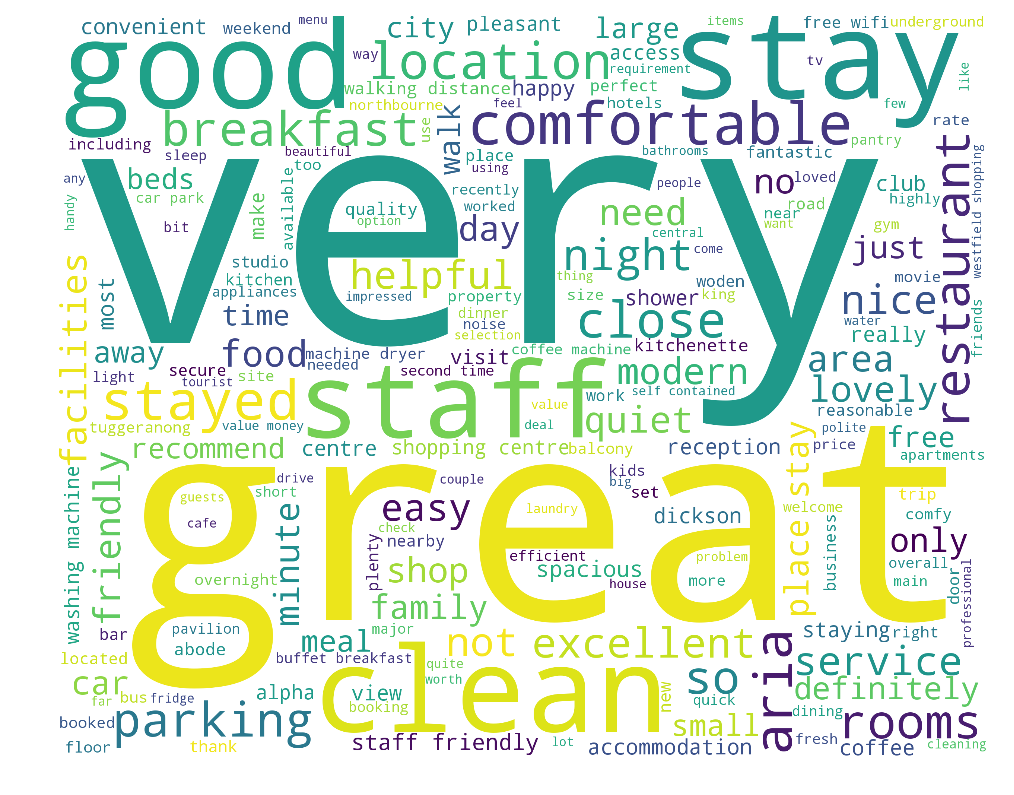

In [167]:
print("Rating = 5")    
wordcloud_draw(joinStr5,'white')

In [168]:
review_dfy3 = review_dfx[review_dfx['rati'] == 3]
print("Rating = 3")
joinStr3 = preprocess(' '.join(review_dfy3['body'].tolist()[:100]))
sorteddict3 = wordListToFreqDict(joinStr3)
for s in sorteddict3: print(str(s))

Rating = 3
(84, 'not')
(80, 'very')
(72, 'no')
(67, 'good')
(54, 'so')
(53, 'staff')
(52, 'stay')
(46, 'clean')
(39, 'rooms')
(39, 'comfortable')
(37, 'only')
(37, 'nice')
(35, 'stayed')
(34, 'night')
(26, 'great')
(26, 'breakfast')
(25, 'small')
(25, 'parking')
(24, 'location')
(24, 'friendly')
(23, 'reception')
(23, 'place')
(23, 'door')
(22, 'service')
(22, 'restaurant')
(22, 'just')
(21, 'little')
(21, 'helpful')
(20, 'free')
(19, 'use')
(19, 'shower')
(18, 'bit')
(18, 'area')
(17, 'like')
(17, 'check')
(17, 'booked')
(17, 'beds')
(16, 'time')
(16, 'coffee')
(16, 'club')
(16, 'bar')
(16, 'air')
(15, 'food')
(15, 'any')
(14, 'way')
(14, 'ok')
(14, 'nights')
(14, 'need')
(14, 'close')
(14, 'car')
(13, 'quiet')
(13, 'pay')
(13, 'motel')
(12, 'walk')
(12, 'sure')
(12, 'restaurants')
(12, 'really')
(12, 'outside')
(12, 'old')
(12, 'day')
(11, 'work')
(11, 'wifi')
(11, 'water')
(11, 'too')
(11, 'told')
(11, 'standard')
(11, 'more')
(11, 'floor')
(11, 'business')
(10, 'tv')
(10, 'sleep')


Rating = 3


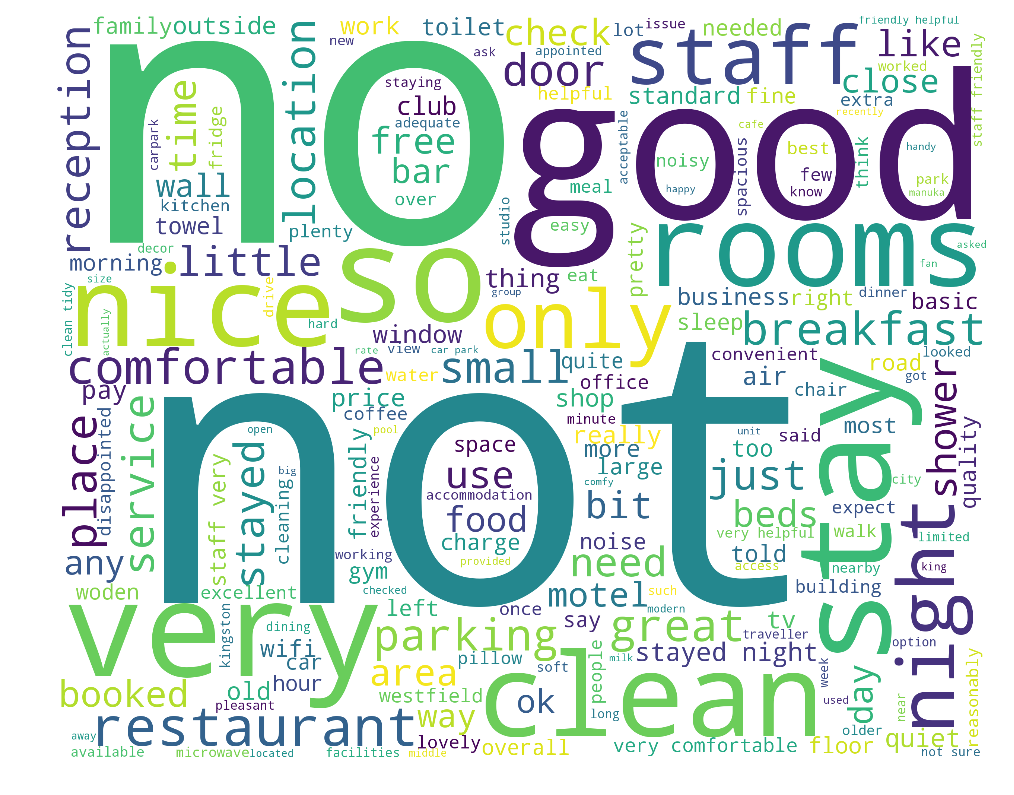

In [169]:
print("Rating = 3")
wordcloud_draw(joinStr3,'white')

In [172]:
review_dfy1 = review_dfx[review_dfx['rati'] == 1]
print("Rating = 1")
joinStr1 = preprocess(' '.join(review_dfy1['body'].tolist()[:100]))
sorteddict1 = wordListToFreqDict(joinStr1)
for s in sorteddict1: print(str(s))

Rating = 1
(164, 'not')
(61, 'stay')
(61, 'so')
(56, 'no')
(56, 'night')
(46, 'staff')
(45, 'very')
(44, 'stayed')
(36, 'rooms')
(31, 'door')
(30, 'booked')
(27, 'only')
(26, 'day')
(25, 'dirty')
(24, 'reception')
(24, 'place')
(24, 'over')
(24, 'more')
(24, 'cleaned')
(22, 'shower')
(22, 'left')
(22, 'floor')
(22, 'desk')
(21, 'like')
(20, 'told')
(20, 'old')
(20, 'need')
(19, 'time')
(19, 'check')
(18, 'went')
(18, 'manager')
(17, 'service')
(17, 'just')
(17, 'given')
(17, 'car')
(16, 'really')
(16, 'guests')
(16, 'checked')
(15, 'way')
(15, 'tv')
(15, 'small')
(15, 'carpet')
(14, 'worst')
(14, 'toilet')
(14, 'quite')
(14, 'pay')
(14, 'park')
(14, 'paid')
(14, 'nights')
(14, 'management')
(14, 'clean')
(14, 'asked')
(14, 'any')
(13, 'wifi')
(13, 'family')
(13, 'come')
(12, 'price')
(12, 'poor')
(12, 'needed')
(12, 'great')
(12, 'good')
(12, 'filthy')
(12, 'breakfast')
(11, '–')
(11, 'receptionist')
(11, 'provided')
(11, 'pm')
(11, 'people')
(11, 'once')
(11, 'mould')
(11, 'motel')
(1

(1, 'dog')
(1, 'dodgy')
(1, 'documents')
(1, 'dizzy')
(1, 'disturb')
(1, 'distance')
(1, 'dissatisfied')
(1, 'disregard')
(1, 'disparity')
(1, 'dismissed')
(1, 'dismayed')
(1, 'dismal')
(1, 'dish')
(1, 'disengaged')
(1, 'discuss')
(1, 'discover')
(1, 'disconnect')
(1, 'disaster')
(1, 'disappointment')
(1, 'director')
(1, 'directed')
(1, 'dire')
(1, 'dinners')
(1, 'dinner')
(1, 'died')
(1, 'die')
(1, 'didnt')
(1, 'dial')
(1, 'detriment')
(1, 'determined')
(1, 'detailed')
(1, 'destination')
(1, 'desperation')
(1, 'designed')
(1, 'design')
(1, 'describing')
(1, 'depot')
(1, 'departed')
(1, 'delights')
(1, 'delayed')
(1, 'delay')
(1, 'decor')
(1, 'declining')
(1, 'deceiving')
(1, 'death')
(1, 'dear')
(1, 'deal')
(1, 'date')
(1, 'dash')
(1, 'darkness')
(1, 'damaged')
(1, 'damage')
(1, 'daggy')
(1, 'cutoff')
(1, 'cut')
(1, 'cushion')
(1, 'curtain')
(1, 'current')
(1, 'cupcakes')
(1, 'cupboards')
(1, 'cup')
(1, 'cuddly')
(1, 'crumbs')
(1, 'crockery')
(1, 'criticisms')
(1, 'credit')
(1, 'creak

Rating = 1


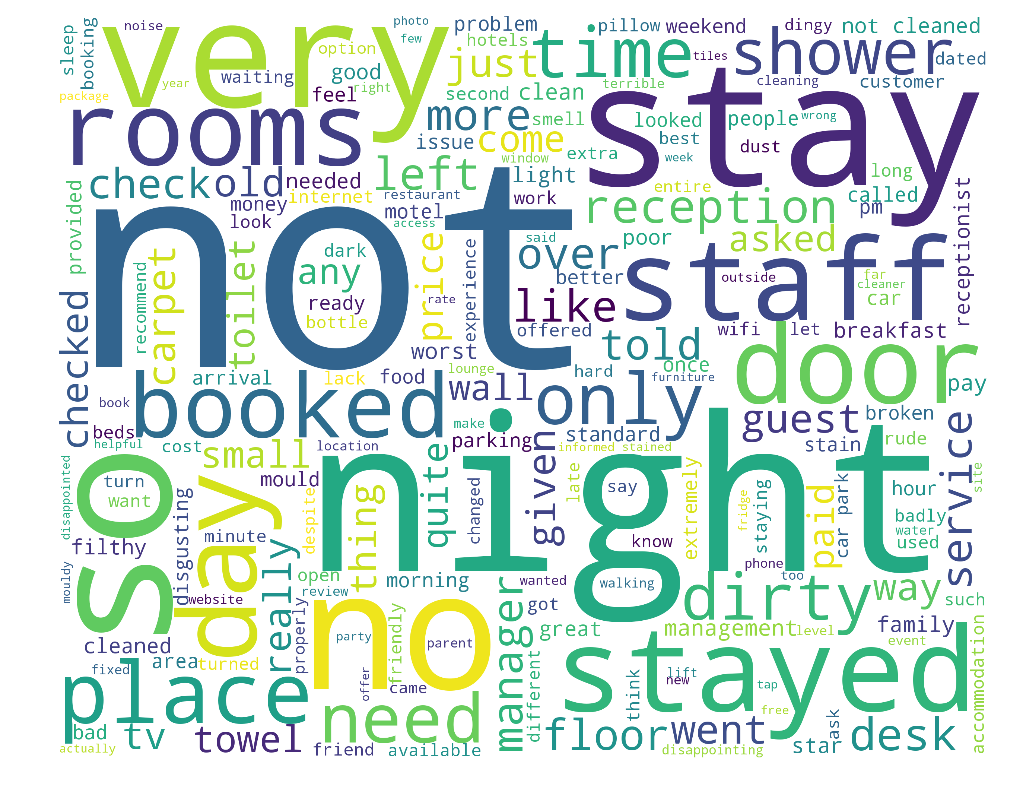

In [173]:
print("Rating = 1")
wordcloud_draw(joinStr1,'white')

In [202]:
input_list = ['this', 'happened', 'all','all', 'more', 'or', 'all', 'more','less']
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

print("Rating = 5")
word5 = ""
for wrdTup in list(find_ngrams(joinStr5, 2))[:5000]:
    word5 += wrdTup[0] + "-" + wrdTup[1] + " "
    
sorteddict5 = wordListToFreqDict(word5.split())
for s in sorteddict5: print(str(s))

Rating = 5
(12, 'place-stay')
(10, 'staff-friendly')
(9, 'very-clean')
(8, 'washing-machine')
(8, 'walking-distance')
(8, 'staff-very')
(8, 'shopping-centre')
(7, 'free-wifi')
(6, 'very-comfortable')
(6, 'machine-dryer')
(5, 'time-stayed')
(5, 'second-time')
(5, 'location-close')
(5, 'friendly-staff')
(5, 'friendly-helpful')
(5, 'coffee-machine')
(5, 'clean-modern')
(5, 'car-park')
(5, 'buffet-breakfast')
(4, 'westfield-shopping')
(4, 'very-reasonable')
(4, 'very-helpful')
(4, 'very-happy')
(4, 'very-good')
(4, 'very-friendly')
(4, 'value-money')
(4, 'self-contained')
(4, 'secure-parking')
(4, 'price-very')
(4, 'most-comfortable')
(4, 'great-place')
(4, 'great-location')
(4, 'good-location')
(4, 'definitely-stay')
(4, 'clean-comfortable')
(4, 'city-centre')
(3, 'very-quiet')
(3, 'very-pleasant')
(3, 'very-close')
(3, 'underground-parking')
(3, 'stayed-nights')
(3, 'stayed-alpha')
(3, 'stay-very')
(3, 'stay-great')
(3, 'stay-aria')
(3, 'staff-so')
(3, 'shops-restaurants')
(3, 'rooms-gre

(1, 'took-advantage')
(1, 'too-tempting')
(1, 'too-staff')
(1, 'too-only')
(1, 'too-kick')
(1, 'too-great')
(1, 'too-dark')
(1, 'told-menu')
(1, 'told-free')
(1, 'toiletries-very')
(1, 'toiletries-food')
(1, 'toilet-night')
(1, 'times-staff')
(1, 'timely-attentive')
(1, 'time-visit')
(1, 'time-staying')
(1, 'time-property')
(1, 'time-food')
(1, 'time-facilities')
(1, 'time-decided')
(1, 'time-conveniently')
(1, 'time-aria')
(1, 'time-accommodation')
(1, 'tiffany-necklace')
(1, 'ticked-boxes')
(1, 'thrilled-eat')
(1, 'thought-price')
(1, 'thoroughfare-below')
(1, 'things-pantry')
(1, 'things-needed')
(1, 'thing-suggest')
(1, 'thing-rooms')
(1, 'thanks-staff')
(1, 'thanks-aria')
(1, 'thank-stayed')
(1, 'thank-guys')
(1, 'thank-family')
(1, 'terminal-definitely')
(1, 'tempting-tuggeranong')
(1, 'teddy-bears')
(1, 'taxi-tourist')
(1, 'taxi-booking')
(1, 'tasty-alpha')
(1, 'taekwon-very')
(1, 'table-chairs')
(1, 'swipe-cards')
(1, 'surrounding-hills')
(1, 'surprisingly-comfortable')
(1, 'su

(1, 'fridge-tea')
(1, 'fridge-great')
(1, 'fridge-freezer')
(1, 'freshly-day')
(1, 'fresh-smelling')
(1, 'fresh-loved')
(1, 'fresh-good')
(1, 'fresh-fruit')
(1, 'fresh-air')
(1, 'frequently-discovered')
(1, 'freezer-second')
(1, 'free-wi')
(1, 'free-pm')
(1, 'free-options')
(1, 'free-new')
(1, 'free-movies')
(1, 'free-internet')
(1, 'free-food')
(1, 'free-easy')
(1, 'free-drinks')
(1, 'free-car')
(1, 'free-asked')
(1, 'foyer-great')
(1, 'fourth-stay')
(1, 'forward-staying')
(1, 'forget-free')
(1, 'footy-clean')
(1, 'football-knockout')
(1, 'food-work')
(1, 'food-very')
(1, 'food-stuff')
(1, 'food-special')
(1, 'food-restaurant')
(1, 'food-quality')
(1, 'food-menu')
(1, 'food-items')
(1, 'food-intolerance')
(1, 'food-good')
(1, 'food-establishments')
(1, 'food-cook')
(1, 'food-coffee')
(1, 'floriade-quests')
(1, 'floor-shower')
(1, 'floor-light')
(1, 'floor-great')
(1, 'floor-better')
(1, 'floor-balcony')
(1, 'floor-avoid')
(1, 'fitness-request')
(1, 'fireplace-near')
(1, 'finishes-comf

Rating = 5


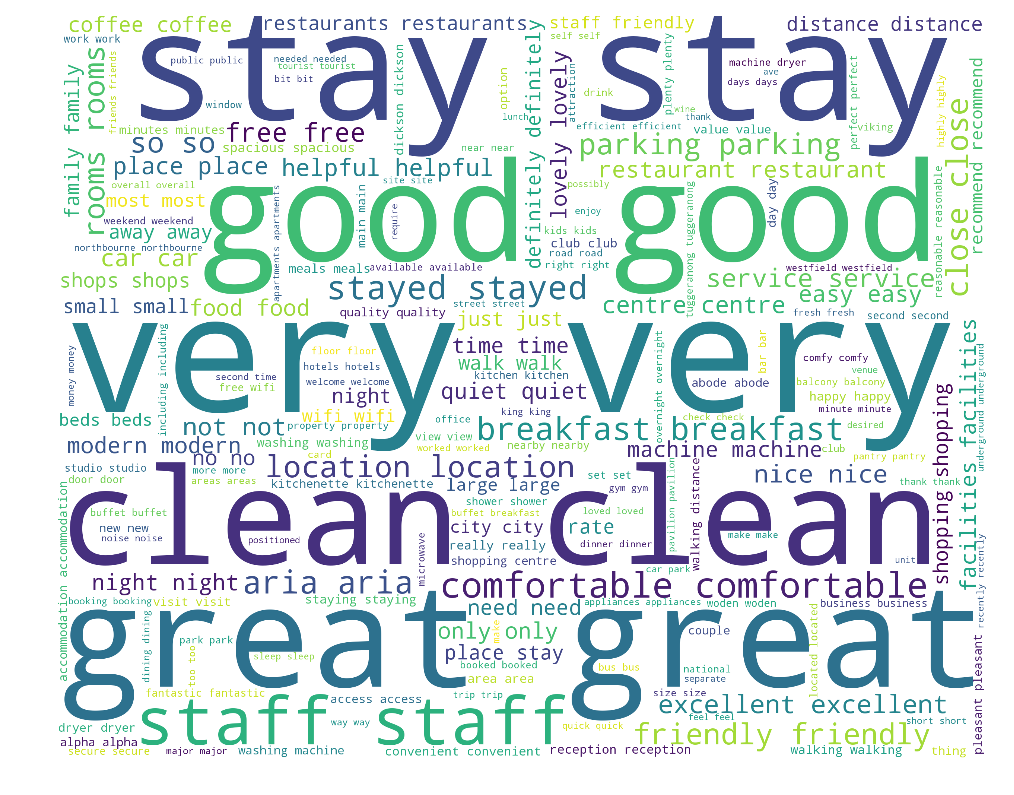

In [205]:
print("Rating = 5")
wordcloud_draw(word5.split(),'white')

In [204]:
print("Rating = 3")
word3 = ""
for wrdTup in list(find_ngrams(joinStr3, 2))[:5000]:
    word3 += wrdTup[0] + "-" + wrdTup[1] + " "
    
sorteddict3 = wordListToFreqDict(word3.split())
for s in sorteddict3: print(str(s))

Rating = 3
(10, 'staff-very')
(9, 'very-comfortable')
(8, 'stayed-nights')
(7, 'very-helpful')
(7, 'staff-friendly')
(6, 'very-friendly')
(6, 'not-sure')
(6, 'friendly-helpful')
(6, 'clean-tidy')
(5, 'washing-machine')
(5, 'very-clean')
(5, 'stayed-night')
(5, 'staff-helpful')
(5, 'shopping-centre')
(5, 'reception-staff')
(5, 'good-value')
(5, 'clean-comfortable')
(5, 'car-park')
(4, 'very-nice')
(4, 'very-good')
(4, 'value-money')
(4, 'tea-coffee')
(4, 'stay-stayed')
(4, 'stay-not')
(4, 'short-walk')
(4, 'no-service')
(4, 'make-sure')
(4, 'good-quality')
(4, 'credit-card')
(4, 'coffee-machine')
(4, 'club-door')
(3, 'wi-fi')
(3, 'walking-distance')
(3, 'very-small')
(3, 'tv-no')
(3, 'stayed-family')
(3, 'stay-staff')
(3, 'soccer-club')
(3, 'so-not')
(3, 'shower-toilet')
(3, 'rooms-clean')
(3, 'pool-gym')
(3, 'pleasant-stay')
(3, 'place-stay')
(3, 'not-worth')
(3, 'not-working')
(3, 'no-complaints')
(3, 'mini-bar')
(3, 'longer-stay')
(3, 'location-great')
(3, 'hot-water')
(3, 'ground-fl

(1, 'walk-away')
(1, 'walk-attractions')
(1, 'waiting-only')
(1, 'wait-mins')
(1, 'visiting-place')
(1, 'visiting-diplomats')
(1, 'visiting-allocated')
(1, 'visited-nights')
(1, 'visit-single')
(1, 'visit-long')
(1, 'visit-listing')
(1, 'visit-german')
(1, 'virtually-groceries')
(1, 'views-garden')
(1, 'views-excellent')
(1, 'view-wall')
(1, 'view-looking')
(1, 'view-comfortable')
(1, 'view-balcony')
(1, 'view-actually')
(1, 'very-wasteful')
(1, 'very-uncomfortable')
(1, 'very-strange')
(1, 'very-spacious')
(1, 'very-soft')
(1, 'very-slow')
(1, 'very-short')
(1, 'very-service')
(1, 'very-satisfactory')
(1, 'very-relaxing')
(1, 'very-quick')
(1, 'very-quaint')
(1, 'very-place')
(1, 'very-patronised')
(1, 'very-outdated')
(1, 'very-old')
(1, 'very-noisily')
(1, 'very-modern')
(1, 'very-long')
(1, 'very-little')
(1, 'very-limited')
(1, 'very-large')
(1, 'very-impressed')
(1, 'very-hesitant')
(1, 'very-heavily')
(1, 'very-effective')
(1, 'very-easy')
(1, 'very-disappointed')
(1, 'very-dark

(1, 'quite-nice')
(1, 'quite-know')
(1, 'quite-heat')
(1, 'quite-dated')
(1, 'quirky-spacious')
(1, 'quiet-staff')
(1, 'quiet-pool')
(1, 'quiet-polite')
(1, 'quiet-old')
(1, 'quiet-ok')
(1, 'quiet-no')
(1, 'quiet-nice')
(1, 'quiet-neighbourhood')
(1, 'quiet-kept')
(1, 'quiet-efficient')
(1, 'quiet-air')
(1, 'quickly-no')
(1, 'quick-travel')
(1, 'quick-thing')
(1, 'quick-prepare')
(1, 'quick-overnight')
(1, 'queue-waiting')
(1, 'queen-uncomfortable')
(1, 'queen-singles')
(1, 'queen-pretty')
(1, 'queen-approx')
(1, 'queanbeyan-city')
(1, 'quality-variable')
(1, 'quality-towels')
(1, 'quality-staff')
(1, 'quality-short')
(1, 'quality-no')
(1, 'quality-movies')
(1, 'quality-customer')
(1, 'quality-breakfast')
(1, 'quaint-great')
(1, 'pushed-reverse')
(1, 'pushed-pillows')
(1, 'purpose-detergent')
(1, 'purchase-quick')
(1, 'pulling-looked')
(1, 'pulled-no')
(1, 'published-rates')
(1, 'public-space')
(1, 'public-so')
(1, 'public-car')
(1, 'provides-free')
(1, 'provides-electric')
(1, 'provid

(1, 'helpful-young')
(1, 'helpful-too')
(1, 'helpful-staff')
(1, 'helpful-rooms')
(1, 'helpful-reception')
(1, 'helpful-pleasant')
(1, 'helpful-perfect')
(1, 'helpful-parking')
(1, 'helpful-overall')
(1, 'helpful-not')
(1, 'helpful-moving')
(1, 'helpful-kind')
(1, 'helpful-efficient')
(1, 'helpful-discussed')
(1, 'helpful-cooking')
(1, 'helpful-attentive')
(1, 'helpful-accommodating')
(1, 'help-desk')
(1, 'hellenic-sunday')
(1, 'height-kids')
(1, 'height-bike')
(1, 'heavily-booked')
(1, 'heating-worked')
(1, 'heating-believe')
(1, 'heater-worked')
(1, 'heated-point')
(1, 'heat-very')
(1, 'heart-so')
(1, 'heard-receptionists')
(1, 'heard-noise')
(1, 'hear-walls')
(1, 'hear-stayed')
(1, 'hear-noise')
(1, 'hear-neighbours')
(1, 'headsets-wanted')
(1, 'heads-disappointing')
(1, 'head-new')
(1, 'head-height')
(1, 'head-game')
(1, 'hawker-belconnen')
(1, 'hate-shower')
(1, 'hate-good')
(1, 'hassle-person')
(1, 'hassle-good')
(1, 'hardy-breath')
(1, 'hard-use')
(1, 'hard-time')
(1, 'hard-pill

(1, 'bar-restaurant')
(1, 'bar-reason')
(1, 'bar-once')
(1, 'bar-items')
(1, 'bar-fine')
(1, 'bar-credit')
(1, 'bar-clean')
(1, 'bar-beers')
(1, 'bar-accommodated')
(1, 'banging-shut')
(1, 'balcony-table')
(1, 'balcony-people')
(1, 'balcony-bonus')
(1, 'balconies-beds')
(1, 'balance-very')
(1, 'bakery-makes')
(1, 'bags-so')
(1, 'bags-rooms')
(1, 'bags-replenished')
(1, 'bags-head')
(1, 'badminton-instead')
(1, 'badly-worn')
(1, 'badly-pillow')
(1, 'bad-too')
(1, 'bad-resort')
(1, 'bad-lot')
(1, 'baamoo-bistro')
(1, 'awkward-toilet')
(1, 'away-too')
(1, 'away-rooms')
(1, 'away-parliament')
(1, 'away-meals')
(1, 'away-good')
(1, 'away-elevators')
(1, 'aware-noise')
(1, 'avoid-wouldnt')
(1, 'avoid-pipes')
(1, 'avoid-any')
(1, 'average-price')
(1, 'average-clean')
(1, 'average-best')
(1, 'average-balcony')
(1, 'avenue-ambivalent')
(1, 'availing-checkout')
(1, 'available-wont')
(1, 'available-reception')
(1, 'available-park')
(1, 'available-order')
(1, 'available-air')
(1, 'availability-tig

Rating = 3


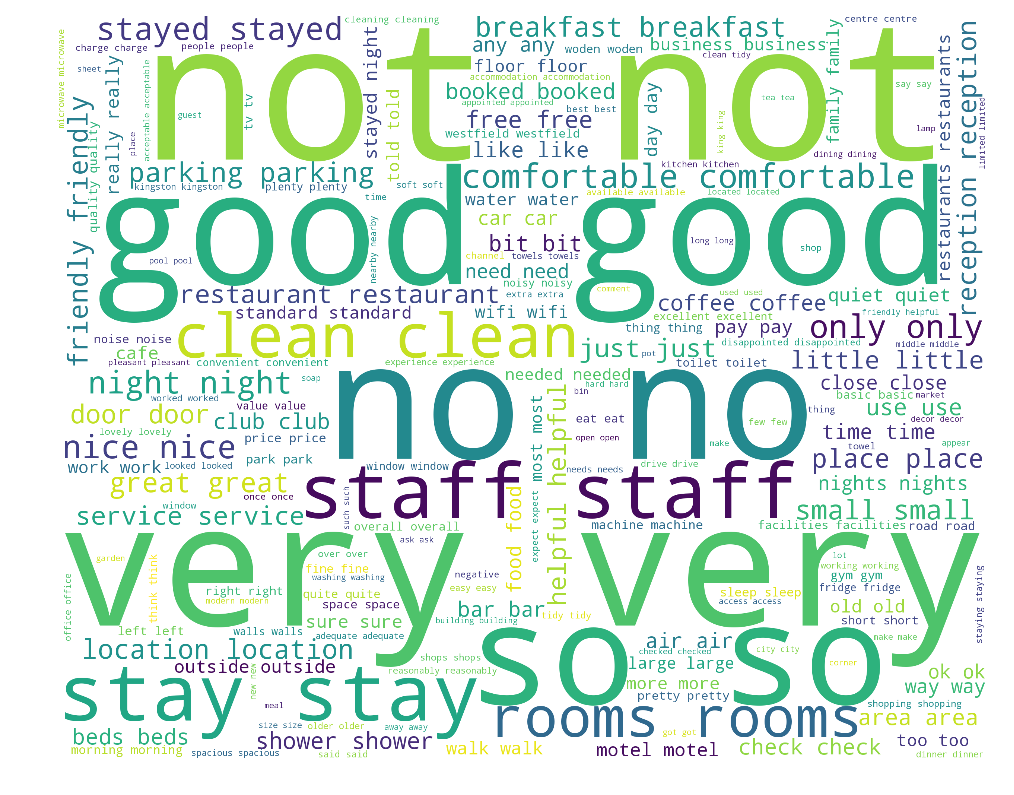

In [206]:
print("Rating = 3")
wordcloud_draw(word3.split(),'white')

In [207]:
print("Rating = 1")
word1 = ""
for wrdTup in list(find_ngrams(joinStr1, 2))[:5000]:
    word1 += wrdTup[0] + "-" + wrdTup[1] + " "
    
sorteddict5 = wordListToFreqDict(word1.split())
for s in sorteddict5: print(str(s))

Rating = 1
(11, 'not-cleaned')
(8, 'car-park')
(5, 'staff-member')
(4, 'so-called')
(4, 'not-work')
(4, 'entire-stay')
(4, 'air-conditioning')
(3, 'wifi-not')
(3, 'very-bad')
(3, 'too-busy')
(3, 'stayed-nights')
(3, 'so-asked')
(3, 'smoke-alarms')
(3, 'rooms-not')
(3, 'roll-away')
(3, 'reception-staff')
(3, 'place-stay')
(3, 'over-priced')
(3, 'old-fashioned')
(3, 'not-used')
(3, 'not-stay')
(3, 'non-smoking')
(3, 'night-stay')
(3, 'night-manager')
(3, 'more-modern')
(3, 'late-check')
(3, 'ground-floor')
(3, 'fully-booked')
(3, 'free-wifi')
(3, 'desk-staff')
(3, 'checked-night')
(3, 'booked-paid')
(2, 'years-ago')
(2, 'wrong-rude')
(2, 'worst-stayed')
(2, 'worst-places')
(2, 'wifi-connection')
(2, 'white-linen')
(2, 'way-too')
(2, 'very-noisy')
(2, 'very-disappointed')
(2, 'unusable-such')
(2, 'tv-not')
(2, 'turn-lights')
(2, 'treasures-versailles')
(2, 'travelled-extensively')
(2, 'time-pm')
(2, 'tickets-audio')
(2, 'tea-coffee')
(2, 'such-connect')
(2, 'stove-carpet')
(2, 'stayed-wee

(1, 'vanity-drawers')
(1, 'value-service')
(1, 'value-not')
(1, 'value-money')
(1, 'valet-team')
(1, 'valance-single')
(1, 'valance-mould')
(1, 'vain-hope')
(1, 'vacuumed-properly')
(1, 'vacuumed-dust')
(1, 'vacuum-cleaner')
(1, 'vacancies-parliamentary')
(1, 'utterly-flabbergasted')
(1, 'utensils-provided')
(1, 'utensils-people')
(1, 'ute-parked')
(1, 'ute-not')
(1, 'ute-night')
(1, 'ute-managers')
(1, 'usually-stay')
(1, 'usual-unfortunately')
(1, 'using-toilet')
(1, 'using-roll')
(1, 'using-incorrect')
(1, 'using-computers')
(1, 'used-stay')
(1, 'used-regular')
(1, 'used-not')
(1, 'used-left')
(1, 'used-external')
(1, 'used-counted')
(1, 'used-coffee')
(1, 'use-stayed')
(1, 'urgent-need')
(1, 'upset-stressed')
(1, 'upset-lack')
(1, 'upper-cabinets')
(1, 'upgraded-sufficient')
(1, 'upgraded-slightly')
(1, 'upgraded-new')
(1, 'updated-not')
(1, 'update-any')
(1, 'unwelcoming-lobby')
(1, 'unwelcoming-cleaner')
(1, 'unwelcome-helping')
(1, 'unusual-checking')
(1, 'untucked-sheets')
(1, 

(1, 'reason-current')
(1, 'realm-organised')
(1, 'realm-online')
(1, 'realm-friday')
(1, 'really-wanted')
(1, 'really-very')
(1, 'really-upset')
(1, 'really-tv')
(1, 'really-spirit')
(1, 'really-sheeted')
(1, 'really-seat')
(1, 'really-pity')
(1, 'really-needs')
(1, 'really-need')
(1, 'really-looking')
(1, 'really-lit')
(1, 'really-great')
(1, 'really-gone')
(1, 'really-feel')
(1, 'really-enjoyed')
(1, 'realise-such')
(1, 'ready-thing')
(1, 'ready-stage')
(1, 'ready-staff')
(1, 'ready-once')
(1, 'ready-mins')
(1, 'ready-half')
(1, 'ready-end')
(1, 'ready-asked')
(1, 'ready-advised')
(1, 'read-review')
(1, 'read-rest')
(1, 'read-entailing')
(1, 'rd-world')
(1, 'rating-overseas')
(1, 'rates-let')
(1, 'rated-time')
(1, 'rated-over')
(1, 'rate-think')
(1, 'rate-motel')
(1, 'rate-evaded')
(1, 'rate-bother')
(1, 'rank-old')
(1, 'rang-different')
(1, 'rang-claim')
(1, 'randomly-turned')
(1, 'randall-argued')
(1, 'raising-complaint')
(1, 'raised-silicone')
(1, 'raised-more')
(1, 'raised-dismis

(1, 'great-advised')
(1, 'graffiti-luckily')
(1, 'got-way')
(1, 'got-small')
(1, 'got-pm')
(1, 'got-overlooked')
(1, 'got-noise')
(1, 'got-mb')
(1, 'got-bags')
(1, 'googling-mouldy')
(1, 'googled-better')
(1, 'googled-accomodation')
(1, 'good-yes')
(1, 'good-way')
(1, 'good-very')
(1, 'good-unless')
(1, 'good-told')
(1, 'good-size')
(1, 'good-service')
(1, 'good-price')
(1, 'good-night')
(1, 'good-location')
(1, 'good-head')
(1, 'gone-sights')
(1, 'gone-experience')
(1, 'gone-downhill')
(1, 'gone-comfortable')
(1, 'going-so')
(1, 'going-othe')
(1, 'going-option')
(1, 'going-carpet')
(1, 'goes-worst')
(1, 'goes-not')
(1, 'god-getting')
(1, 'glove-box')
(1, 'globes-bedside')
(1, 'glazing-windows')
(1, 'glasses-quite')
(1, 'glasses-no')
(1, 'glasses-friends')
(1, 'given-wrong')
(1, 'given-way')
(1, 'given-truck')
(1, 'given-sent')
(1, 'given-second')
(1, 'given-noticed')
(1, 'given-not')
(1, 'given-menu')
(1, 'given-map')
(1, 'given-key')
(1, 'given-just')
(1, 'given-drink')
(1, 'given-da

(1, 'bar-atmosphere')
(1, 'banquet-staff')
(1, 'bannister-rail')
(1, 'banging-roof')
(1, 'balcony-rooms')
(1, 'bags-small')
(1, 'bags-holding')
(1, 'bag-emptied')
(1, 'bag-closet')
(1, 'badly-torn')
(1, 'badly-stained')
(1, 'badly-need')
(1, 'badly-let')
(1, 'badly-laid')
(1, 'badly-far')
(1, 'bad-wanted')
(1, 'bad-value')
(1, 'bad-stayed')
(1, 'bad-smell')
(1, 'bad-feign')
(1, 'bad-experience')
(1, 'bad-cramped')
(1, 'backyard-stayed')
(1, 'b-r')
(1, 'b-manager')
(1, 'b-c')
(1, 'axe-murderer')
(1, 'awning-needed')
(1, 'away-so')
(1, 'away-requested')
(1, 'away-quiet')
(1, 'away-pre')
(1, 'away-needed')
(1, 'away-bungalows')
(1, 'away-booked')
(1, 'away-any')
(1, 'avoided-open')
(1, 'avoid-stay')
(1, 'avoid-place')
(1, 'average-woke')
(1, 'avenue-discuss')
(1, 'available-sports')
(1, 'available-sites')
(1, 'available-rooms')
(1, 'available-reason')
(1, 'available-immediately')
(1, 'available-dingy')
(1, 'auto-doors')
(1, 'australia-overseas')
(1, 'australia-hotels')
(1, 'aussie-capital

Rating = 1


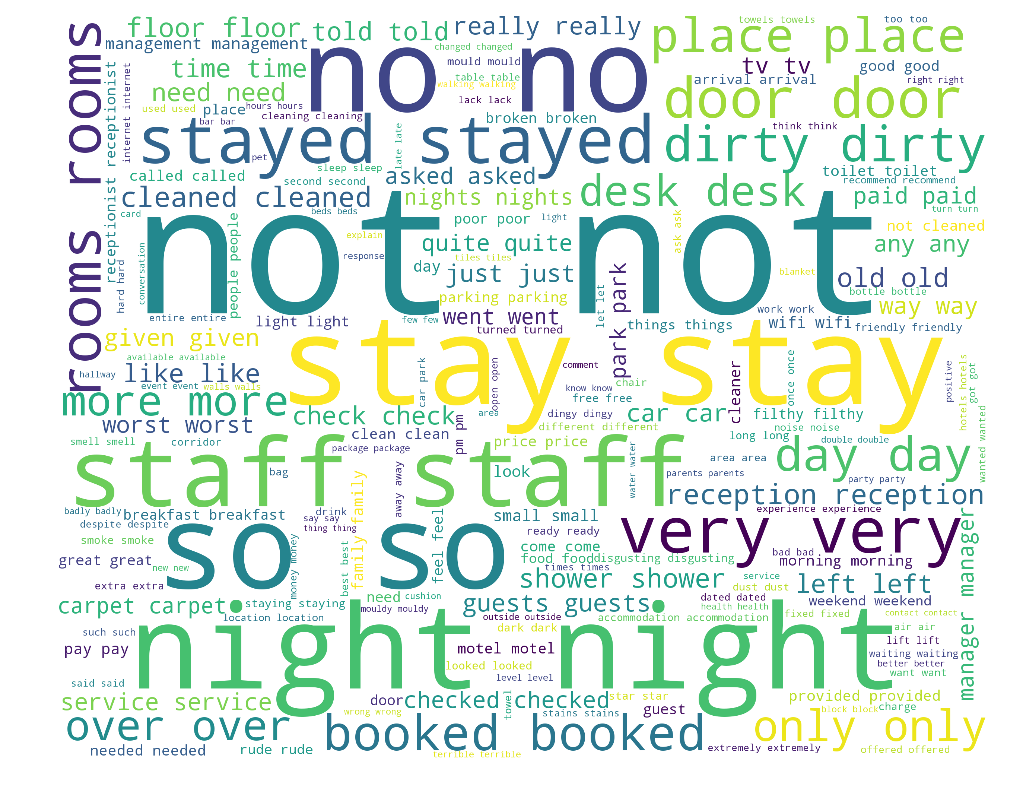

In [208]:
print("Rating = 1")
wordcloud_draw(word1.split(),'white')